In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os
import pylab
import pandas as pd
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import keras
import seaborn as sns
%matplotlib inline
sns.set()
# http://www.temis.nl/uvradiation/product/uvi-uvd.html
# https://www.epd.gov.hk/eia/register/report/eiareport/eia_1482008/EIA/html/Text/S6_WQ.htm

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def make_ts(x):
    try: 
        return pd.Timestamp(x) 
    except:
        return np.nan
    
    
def check_na(var):
    if var == 'n/a':
        return np.nan
    else:
        return var
    
    
def split_time(var):
    var = str(var)
    year = var[0:4]
    month = var[4:6]
    day = var[6:8]
    hour = var[8:10]
    minute = var[10:12]
    try:
        return pd.Timestamp(year + '-' + month + '-' + day + ' ' + hour + ':'  + minute)
    except:
        return np.nan

    
def pdistf(x1,y1,x2,y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)
    
plt.rc('font', family = 'serif', size = 8)

plt.close('all')

In [3]:
uv_index = 8.4

In [4]:
def index_to_intensity(uv_index):
    '''
    calculate the expected uv radiation based on the uv index
    this function takes the spectrum shown here:
    https://www.hko.gov.hk/wxinfo/uvindex/english/wisuvindex.htm
    and determines the scale necessary to apply to the spectrum
    to have the uv index match the fed index. This scale solution
    is then applied to the spectrum and summed to get the uv radiation
    a translation of index to uva is shown here
    https://www.hko.gov.hk/wxinfo/uvinfo/uvinfo_e.html
    
    '''
    # plausible distribution
    uv_wl = np.arange(290, 401)
    # units are mW / m2 nm
    intensity = np.array([[290, 0.001], [295, 1], [300, 10], [310, 200], [330, 800], [400, 820]])
    weight = np.array([[290, 1], [300, 1], [330, 0.001], [400, 0.0001]])

    uv_intensity = np.interp(uv_wl, intensity[:,0], np.log(intensity[:,1]))
    uv_weight    = np.interp(uv_wl, weight[:,0]   , np.log(weight[:,1]))

    uv_intensity = np.exp(uv_intensity)
    uv_weight    = np.exp(uv_weight)
    plt.plot(uv_wl, uv_intensity)
    plt.plot(uv_wl, uv_weight)
    plt.yscale('log')
    rad = 0
    for ind, wl in enumerate(uv_wl):
        rad = rad + (uv_intensity[ind] * uv_weight[ind])

    index_0 = 0.04 * rad

    # if the spectra is always the same, then one can assume the only
    # difference between different UV_index values is the intensity
    # This can be pulled out of the integral and treated as a scaling factor 
    # on the integral of intensity * weight

    # uv_index    = 0.04  * np.sum(m1 * uv_intensity * uv_weight)
    # uv_index_0  = 0.04  * np.sum(     uv_intensity * uv_weight)
    # divide one equation by the other

    m = uv_index / index_0
    uv = m * uv_intensity

    return(0.001 * uv.sum())


45.48114573686844

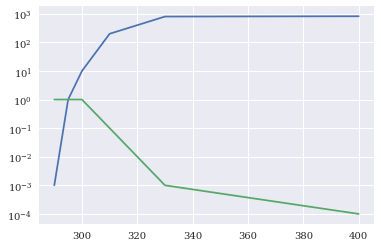

In [6]:
''' 
a translation of index to uva is shown here
https://www.hko.gov.hk/wxinfo/uvinfo/uvinfo_e.html
for an index of 8.4, the UVA radiation was 49.8
the current translation is equal to test 
'''
test = index_to_intensity(uv_index)
test
# 45.48
# this should be higher (~49), but there are of course numerous uncertainties

# Radiation

In [7]:
# radiation file
# this is direct solar radiation from KP station, which is close to HKO
solar_file = r'p:\11200975-hongkongwaq\WAQ\01_data\meteo\KP_direct.csv'
solar_df = pd.read_csv(solar_file)
solar_df['time'] = solar_df['Date'].apply(make_ts)
solar_df.dropna(inplace = True, axis = 0)
solar_df['MJ/m2'] = solar_df['MJ/m2'].apply(lambda x: x.replace('*',''))
solar_df['MJ/m2'] = solar_df['MJ/m2'].apply(check_na)
solar_df['MJ/m2'] = solar_df['MJ/m2'].apply(lambda x: float(x))
# mega to kilo to joules per hour to per second to PAR
solar_df['rate'] = solar_df['MJ/m2'] * 1e6 * 0.45 /3600

# UV

In [8]:
# UV file
# not clear where this is taken
uv_file = r'p:\11200975-hongkongwaq\WAQ\01_data\meteo\uv_15min\UV_df.csv'
uv_df = pd.read_csv(uv_file)
uv_df['time'] = uv_df['time'].apply(split_time)
uv_df.dropna(inplace = True, axis = 0)
uv_df['uv'] = uv_df['uv'].apply(lambda x: float(x))
#uv_df['uv'].iloc[[uv_df['uv'] > 90]] = np.nan
uv_df['uv'] = uv_df['uv'].apply(lambda x: np.nan if x > 90.0 else x)
uv_df.dropna(inplace = True, axis = 0)

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Clouds

In [9]:
cloud_file = r'p:\11200975-hongkongwaq\WAQ\01_data\meteo\hko_cld.csv'
cloud_df = pd.read_csv(cloud_file)
cloud_df['time'] = cloud_df['time'].apply(make_ts)
cloud_df['hour'] = cloud_df['time'].apply(lambda x: x.hour)

cloud_df.dropna(inplace = True, axis = 0)
cloud_df['day'] =  cloud_df['time'].apply(lambda x: x.timetuple().tm_yday )
cloud_df['cloud'] = cloud_df['cloud'].apply(lambda x: float(x))
cloud_df.dropna(inplace = True, axis = 0)

# Combine Data


KeyboardInterrupt: 

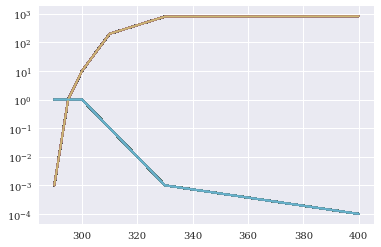

In [10]:
plt.close('all')
# set indicies
try:
    solar_df.set_index('time', inplace = True)
    solar_df = solar_df[~solar_df.index.duplicated(keep='first')]
    cloud_df.set_index('time', inplace = True)
    uv_df.set_index('time', inplace = True)
except:
    pass

# concatenate
X = pd.concat([solar_df['rate'], cloud_df['cloud'], cloud_df['hour'], cloud_df['day'], uv_df['uv']], axis = 1, ignore_index = False)
# I have checked the concatenation validity on a random 2019 and a random 2012 datapoint. rate, cloud, and uv check out
# eliminate nighttime data
X['rate'] = X['rate'].apply(lambda x: np.nan if x == 0 else x)
X['uv'] = X['uv'].apply(lambda x: np.nan if x == 0 else x)

X.dropna(axis = 0, inplace = True)

Y = X[['uv','hour']].copy()
X_m = X[['day', 'cloud', 'rate', 'hour']].copy()
Y['uv_rate'] = Y['uv'].apply(index_to_intensity)
RadSurf = X_m['rate']

In [ ]:
plt.plot(Y['uv'].apply(index_to_intensity) / X_m['rate'])
plt.title('fraction uv of visible light')
plt.ylabel('-')

In [ ]:
sum(Y['uv'].apply(index_to_intensity) / X_m['rate'] < 1) / len(X_m['rate'])

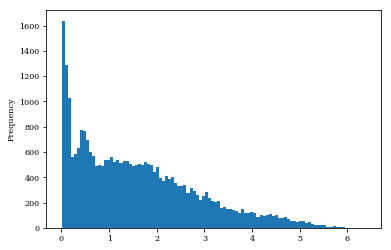

In [356]:
Y['uv'].apply(index_to_intensity).plot.hist(bins = 100)

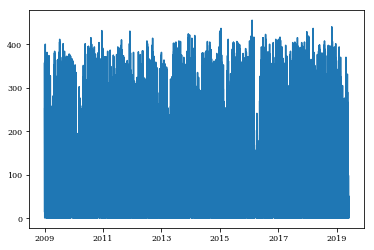

In [346]:
plt.plot(X_m['rate'])

In [ ]:
ax = Axes3D(plt.figure())
ax.scatter(X_m[X_m.columns[0]], X_m[X_m.columns[1]], X_m[X_m.columns[2]], c = Y )

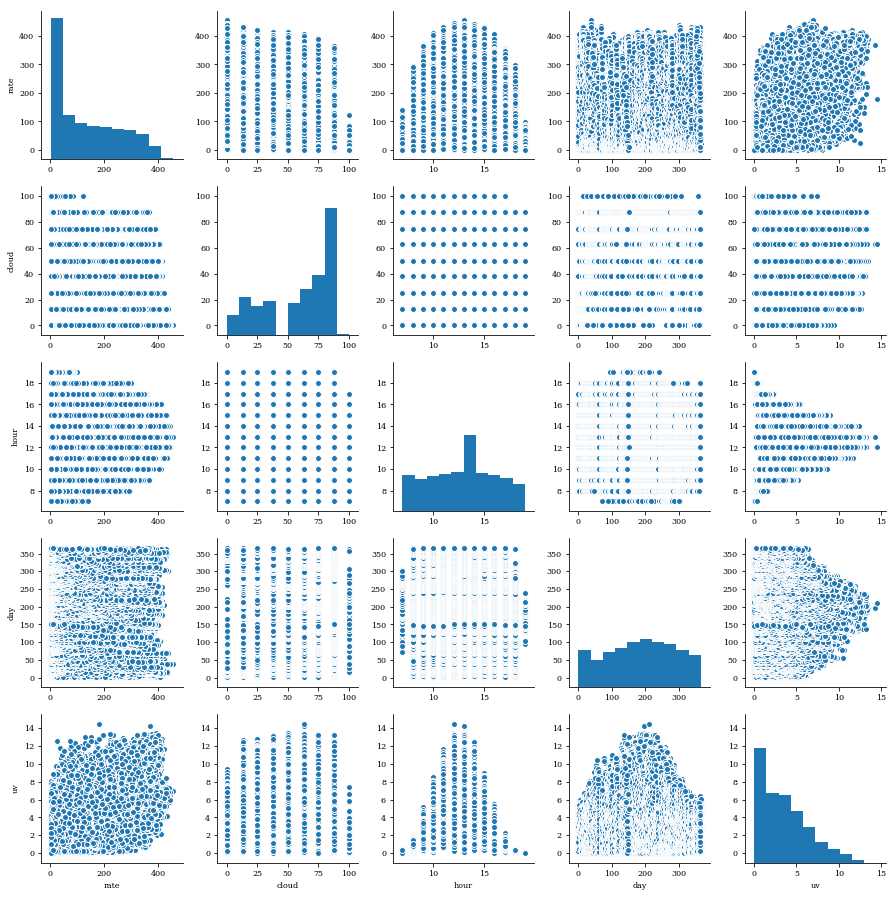

In [154]:
sns.pairplot(X)

Text(0.5,0,'cloud cover')

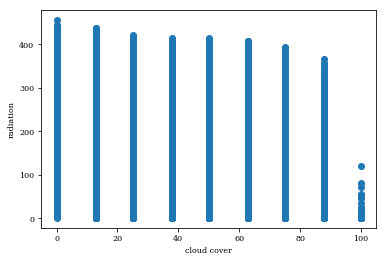

In [155]:
plt.figure()
plt.scatter(X_m['cloud'], X_m['rate'])
plt.ylabel('radiation')
plt.xlabel('cloud cover')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


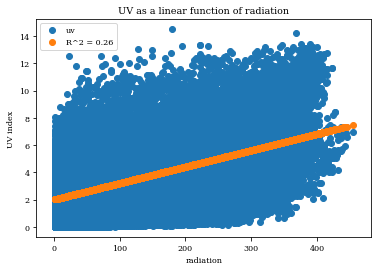

In [163]:
plt.figure()
plt.scatter(X_m['rate'], Y)
plt.xlabel('radiation')
plt.ylabel('UV index')
clf = linear_model.LinearRegression()
clf.fit(X_m['rate'].reshape(-1, 1), np.array(Y))
pred = clf.predict(X_m['rate'].reshape(-1, 1))
plt.scatter(X_m['rate'], pred, label = 'R^2 = ' + '%.2f' % clf.score(X_m['rate'].reshape(-1, 1), Y))
plt.title('UV as a linear function of radiation')
plt.legend()

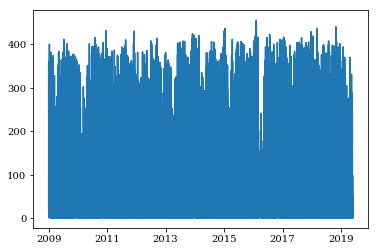

In [206]:
plt.plot(X_m['rate'])

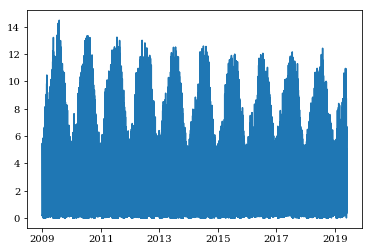

In [207]:
plt.plot(Y)

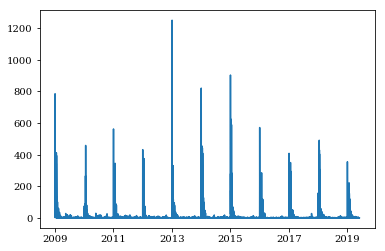

In [210]:
plt.plot(X_m['rate']/ (Y * X_m['day']))

# Models

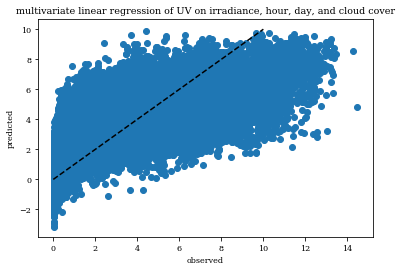

In [164]:
###############################################################################
# LINEAR MODEL
###############################################################################

clf = linear_model.LinearRegression(fit_intercept = True, normalize = True)
clf.fit(X_m, Y)
pred = clf.predict(X_m)
plt.figure(4)
plt.scatter(Y, pred)
plt.plot([0,10],[0,10],'k--')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('multivariate linear regression of UV on irradiance, hour, day, and cloud cover')
plt.show()


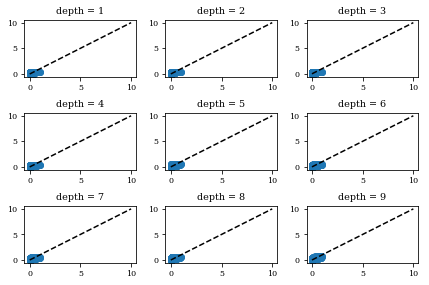

In [183]:
###############################################################################
# RANDOM FOREST MODEL
###############################################################################
for depth in range(1,10):
    rf = RandomForestRegressor(n_estimators=2000, max_depth = depth, random_state = 42)
    rf.fit(X_m, Y)
    feature_importance_data = []
    features = X_m.columns
    for feature_name, feature_importance in zip(features, rf.feature_importances_):
        feature_importance_data.append({'feature' : feature_name, 'importance' : feature_importance})
    
    feature_importance_data = pd.DataFrame(feature_importance_data)
    plt.figure(5)
    plt.subplot('3' + '3' + str(depth))
    Y_h = rf.predict(X_m)
    plt.scatter(Y, Y_h)
    plt.title('depth = ' + str(depth))
    plt.plot([0,10],[0,10],'k--')
plt.tight_layout()

In [184]:
X_m = X[['day', 'cloud', 'rate', 'hour']].copy()
Y = X['uv'].copy()

# normalize
for col in X_m.columns:
    X_m[col] = (X_m[col] - X_m[col].mean()) / np.std(X_m[col])
Y = (Y - Y.mean()) / np.std(Y)

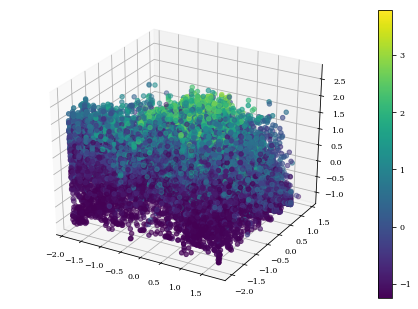

In [185]:
# show normalized
fig = plt.figure()
ax = Axes3D(fig)
im = ax.scatter(X_m[X_m.columns[0]], X_m[X_m.columns[1]], X_m[X_m.columns[2]], c = Y )
fig.colorbar(im, ax = ax)
plt.show()

In [186]:
###############################################################################
# SUPPORT VECTOR MACHINE
###############################################################################

from sklearn import svm
clf = svm.SVR()
clf.fit(X_m, Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [187]:
Y_h = clf.predict(X_m)

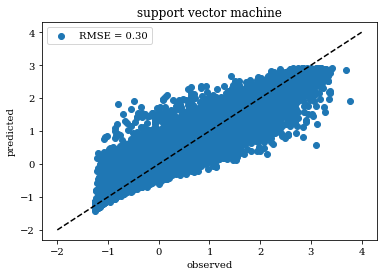

In [191]:
RMSE = np.sqrt(mean_squared_error(Y, Y_h))
plt.scatter(Y, Y_h, label = 'RMSE = %.2f' % RMSE)
plt.title('depth = ' + str(depth))
plt.plot([-2,4],[-2,4],'k--')
plt.title('support vector machine')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.legend()
plt.show()

In [197]:
X_m = X[['day', 'cloud', 'rate', 'hour']].copy()
Y = X['uv'].copy()

# normalize
for col in X_m.columns:
    X_m[col] = X_m[col] / np.max(X_m[col])
Y = Y / np.max(Y)

In [198]:
###############################################################################
# NEURAL NET
###############################################################################
    
model = keras.Sequential()

#input layer
model.add(keras.layers.Dense(4, input_dim = 4, activation = 'relu'))

# hidden layer
model.add(keras.layers.Dense(12, activation = 'relu'))

# hidden layer
model.add(keras.layers.Dense(8, activation = 'relu'))

# hidden layer
model.add(keras.layers.Dense(8, activation = 'relu'))

# hidden layer
model.add(keras.layers.Dense(4, activation = 'relu'))

#output layer
model.add(keras.layers.Dense(1, activation = 'relu')) 

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics=['accuracy'])

history = model.fit(X_m, Y, epochs=50, batch_size=100)


Epoch 1/50
29021/29021 [==============================] - 1s 42us/step - loss: 0.0345 - acc: 0.0000e+00
Epoch 2/50
29021/29021 [==============================] - 0s 12us/step - loss: 0.0191 - acc: 0.0000e+00
Epoch 3/50
29021/29021 [==============================] - 0s 12us/step - loss: 0.0139 - acc: 0.0000e+00
Epoch 4/50
29021/29021 [==============================] - 0s 12us/step - loss: 0.0103 - acc: 3.4458e-05
Epoch 5/50
29021/29021 [==============================] - 0s 12us/step - loss: 0.0083 - acc: 0.0000e+00
Epoch 6/50
29021/29021 [==============================] - 0s 14us/step - loss: 0.0068 - acc: 3.4458e-05
Epoch 7/50
29021/29021 [==============================] - 0s 12us/step - loss: 0.0061 - acc: 3.4458e-05
Epoch 8/50
29021/29021 [==============================] - 0s 13us/step - loss: 0.0056 - acc: 3.4458e-05
Epoch 9/50
29021/29021 [==============================] - 0s 12us/step - loss: 0.0053 - acc: 3.4458e-05
Epoch 10/50
29021/29021 [==============================] - 0s 12

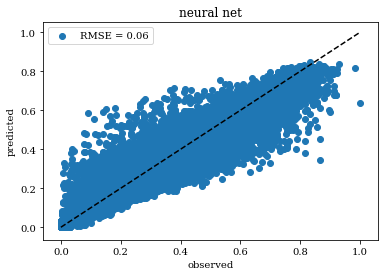

In [201]:
Y_h = model.predict(X_m)
RMSE = np.sqrt(mean_squared_error(Y, Y_h))
plt.scatter(Y, Y_h,  label = 'RMSE = %.2f' % RMSE)
plt.title('depth = ' + str(depth))
plt.plot([0,1],[0,1],'k--')
plt.title('neural net')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.legend()
plt.show()